In [1]:
import numpy as np
import pandas as pd
import math
import os
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time
import ot
from pathlib import Path
import time

n = 1000
x_dim = 2
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 100
seq_len = 10
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 500
train_vaca = 0
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

res_path = Path('../res')
log_dir = res_path / f'experiments_adj_generation_unfair_decisions_10_steps_2_interventions'
clf_path = log_dir / (f"c_model_" + ".pth")
efforts_path = log_dir / (f"effort_model" + ".pth")
gan_path = log_dir / (f"gan_model_" + str(gan_epochs) + "_" + str(g_hidden_size) + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(6)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

cuda:0


In [2]:
def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx = to_tensor(z, x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [3]:
def demographic_parity(sensi, pred_y):

    s0 = sum(sensi.squeeze() == 0)
    s1 = sum(sensi.squeeze() == 1)
    y0 = sum(pred_y.squeeze() == 0)
    y1 = sum(pred_y.squeeze() == 1)
    y1_s0 = sum(pred_y[sensi.squeeze() == 0].squeeze() == 1) / s0
    y1_s1 = sum(pred_y[sensi.squeeze() == 1].squeeze() == 1) / s1
    print(f"#(S=0): {s0}, #(S=1): {s1}, #(y0): {y0}, #(y1): {y1}, P(y=1|s=0)={y1_s0:.3f}, P(y=1|s=1)={y1_s1:.3f}")
    return y1_s1 - y1_s0

In [4]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens, dropout_prob = 0.2):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_prob))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

        self.dropout_prob = dropout_prob

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb, num_samples = 10):
        pred = []

        for _ in range(num_samples):
            sx_mb = torch.cat([s_mb, x_mb], dim=1)
            output = self.model(sx_mb)
            pred.append(output.unsqueeze(0))  # Add the unsqueezed prediction
        return  torch.mean(torch.cat(pred, dim=0), dim=0)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    # @count_time
    def fit(self, loader, valid_loader, save_path, device, max_epochs = 300, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while epoch < max_epochs:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                # torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!, Counter: {counter}")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                pred_y_mb = self(s_mb, x_mb[:, i].to(device))
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [5]:
def gen_initial_data(n, noise_factor = 1, seed = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    s0 = torch.bernoulli(torch.empty(n,1).uniform_(0,1)).numpy()
    x0 = np.random.randn(n, 1)*noise_factor + np.sin(s0)
    z0 = np.cos(x0) + np.random.randn(n, 1)*noise_factor + np.sin(s0)
    y = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-x0-z0+2.1))))
    return torch.from_numpy(s0), to_tensor(x0, z0), y

def sequential_data(s0, x0, y0, seq_len, hiddens, l=0.5, noise_factor = 1, seed=0):
    n = s0.size()[0]
    model = TrueModel(hiddens, seed)
    sx = to_tensor(s0, x0)
    model.fit(s0, x0, y0.to(dtype=torch.float32))
    sx.requires_grad = True
    sx = sx.to(dtype=torch.float32)
    theta_t = abs(model.optim.param_groups[0]['params'][-1].item())
    print(theta_t)
    
    x = x0
    y= y0
    prevx = x.numpy()
    prevy = y
    s0 = s0.numpy()
    nx = np.empty_like(s0)
    nz = np.empty_like(s0)
    ny = np.empty_like(s0)
    for i in range(1, seq_len):
        yhat = model.predict(s0, prevx)
        for j in range(n):
            
            if yhat[j] == 1 and prevy[j] == 0:
                l = -l
            elif yhat[j] == 1 and prevy[j] == 1:
                l = l
            else:
                l = 0
            nx[j] = np.random.randn()*noise_factor + prevx[j][0] + l*theta_t + s0[j]*1 + (1-s0[j])*0.2
            nz[j] = np.random.randn()*noise_factor + prevx[j][1] + l*theta_t + s0[j]*1 + (1-s0[j])*0.2
        ny = torch.bernoulli(torch.from_numpy(1 /(1+  np.exp(-nx-nz+2.1))))
        prevx = to_tensor(nx, nz)
        x = torch.cat((x, prevx),0)
        y = torch.cat((y, ny),0)
        prevx = prevx.numpy()
        prevy = ny
    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y, model
        

In [6]:
s0, x0, y0 = gen_initial_data(n, noise_factor=0.1, seed=0)
x, y, model = sequential_data(s0, x0, y0, seq_len, hiddens, l=0.5, noise_factor=0.1, seed=0)

TrueModel Fit Done in 88 epochs!
0.15474778413772583


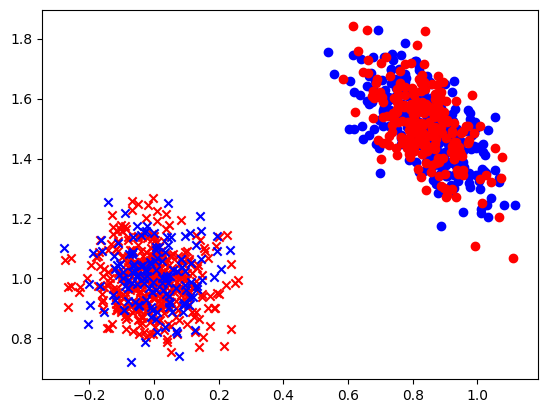

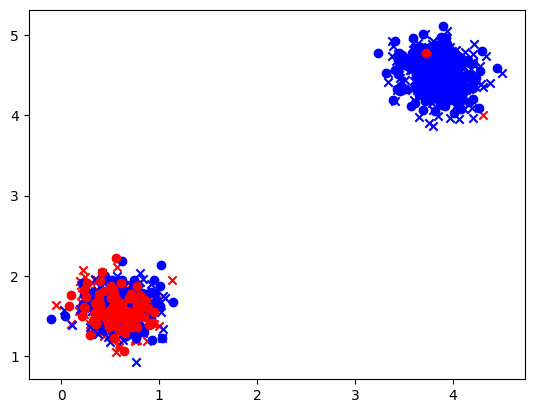

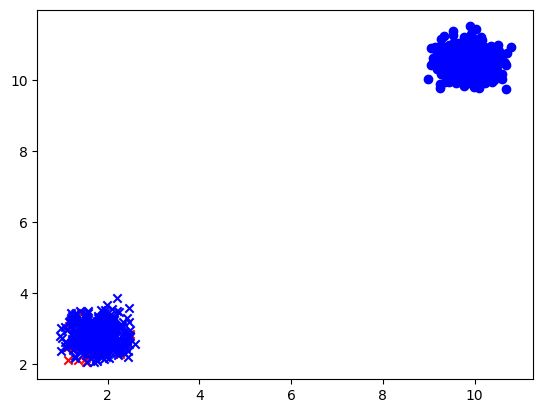

In [7]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []
s_temp = np.array(s0)
for i in range(n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red')
ax.scatter(x11, z11, marker = 'o', color = 'blue')
ax.scatter(x01, z01, marker = 'x', color = 'blue')
ax.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(3*n, 4*n):
    if y[i] == 1 and s_temp[i % 100] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % 100] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % 100] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red')
axm.scatter(x11, z11, marker = 'o', color = 'blue')
axm.scatter(x01, z01, marker = 'x', color = 'blue')
axm.scatter(x10, z10, marker = 'o', color = 'red')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(9*n, 10*n):
    if y[i] == 1 and s_temp[i % n] == 1:
        x11.append(x[i][0])
        z11.append(x[i][1])
    elif y[i] == 1 and s_temp[i % n] == 0:
        x01.append(x[i][0])
        z01.append(x[i][1])
    elif y[i] == 0 and s_temp[i % n] == 1:
        x10.append(x[i][0])
        z10.append(x[i][1])
    else:
        x00.append(x[i][0])
        z00.append(x[i][1])


fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')


In [8]:
class NaiveCLF(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        self.linear = nn.Linear(x_dim, 1)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, s, x):
        return torch.round(torch.sigmoid(self.linear(x)))
    
    def prob(self, s, x):
        return torch.sigmoid(self.linear(x))
    
    def fit(self, s, x, y, patience=10):
        x = tensor(x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(s, x)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item()}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience or epoch >= 5000:
                    
                    break
#         print(f"TrueModel Fit Done in {epoch} epochs!")

In [9]:
def compute_distance_loss(data, check_divergence = False):
    pos_data = data[data[:, 0] == 1, 1:]
    neg_data = data[data[:, 0] == 0, 1:]
    
    loss = sinkhorn_distance(pos_data, neg_data, check_divergence)
    # loss = ot.sinkhorn2(w1, w2, M, 0.1)
    return loss


def sinkhorn_distance(data1, data2, check_divergence, epsilon = 0.1, num_iters = 100, tol=1e-3):
    n, m = data1.shape[0], data2.shape[0]
    a = torch.ones(n) / n
    b = torch.ones(m) / m
    a.to(device)
    b.to(device)

    C = torch.cdist(data1, data2, p=2) ** 2
    C = C / C.max()

    K = torch.exp(-C / epsilon) 
    K.to(device)

    u = torch.ones(n).to(device)
    v = torch.ones(m).to(device)

    for i in range(num_iters):
        
        u_prev = u.clone()
        v_prev = v.clone()
        u = a.to(device) / (K.to(device) @ v.to(device) + 1e-8)
        v = b.to(device) / (torch.transpose(K, 0, 1).to(device) @ u.to(device) + 1e-8)

        if check_divergence:
            u_change = torch.norm(u - u_prev)
            v_change = torch.norm(v - v_prev)
            if u_change < tol and v_change < tol:
                print(f"Converged in {i} iterations")
                break

    plan = torch.diag(u) @ K @ torch.diag(v)
     
    distance = torch.sum(plan * C).to(device)
    
    return distance

In [10]:
def gen_gaussian(sample_size, seed=0):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    mu0, sigma0 = [-1, -1], [[5, 1], [1, 5]]
    mu1, sigma1 = [1, 1], [[5, 1], [1, 5]]
    s0 = np.ones(sample_size, dtype=float) * 0
    X0 = np.random.multivariate_normal(mean=mu0, cov=sigma0, size=sample_size)
    s1 = np.ones(sample_size, dtype=float) * 1
    X1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=sample_size)

    s = np.concatenate((s0, s1))
    X = np.vstack((X0, X1))
    perm = list(range(int(2*sample_size)))
    np.random.shuffle(perm)
    s = s[perm]
    X = X[perm]
    y=np.random.binomial(1, 1/(1+np.exp(-(X[:,0]+2*X[:,1]-1))))

    return s, X, y

def sequential_data(s0, x0, y0, seq_len, l=0.5, noise_factor = 1, b = 0.5, seed=0, ground_truth = True):
    torch.manual_seed(seed)
    np.random.seed(seed)
    l_og = l
    n = len(s0)
    model = NaiveCLF(x0.shape[1])
    x0 = torch.from_numpy(x0).to(dtype=torch.float32)
    x0.requires_grad = True
    y0 = torch.from_numpy(y0).to(dtype=torch.float32)
    model.fit(s0, x0, y0.view(n, 1))
    theta_t = abs(model.optim.param_groups[0]['params'][-1].item())

    
    x = torch.empty(n, seq_len, x0.shape[1])
    y= torch.empty(n, seq_len, 1)
    x[:, 0, :] = x0
    y[:, 0, :] = y0.view(n, 1)

    prevy = y0
    
    for i in range(1, seq_len):
        yhat = model(s0, x[:,i-1,:])
        for j in range(n):
            
            if yhat[j] == 1 and prevy[j] == 0:
                l = -l_og
            elif yhat[j] == 1 and prevy[j] == 1:
                l = l_og
            else:
                l = 0
            for k in range(x0.shape[1]):
                x[j, i, k] = np.random.randn()*noise_factor + x[j, i-1, k] + l*theta_t + s0[j]*b + (1-s0[j])*0.1
        if ground_truth:
            y[:, i, :] = torch.bernoulli((1 /(1+  torch.exp(-(x[:,i,0]+3*x[:,i,1]-1))))).view(n, 1)
        else:
            y[:, i, :] = model(s0, x[:, i, :])
        prevy = y[:, i, :]
        

    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y, model

s0, x0, y0 = gen_gaussian(int(n/2), seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, b=0.5, seed=52)

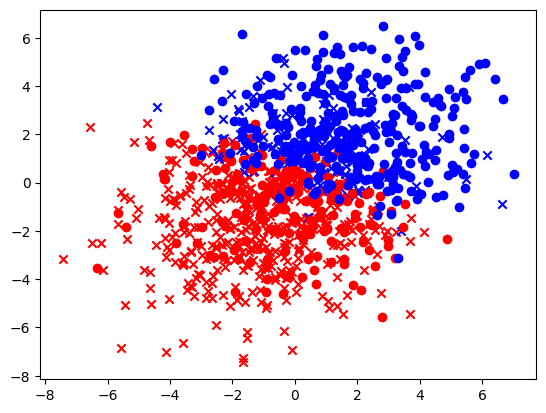

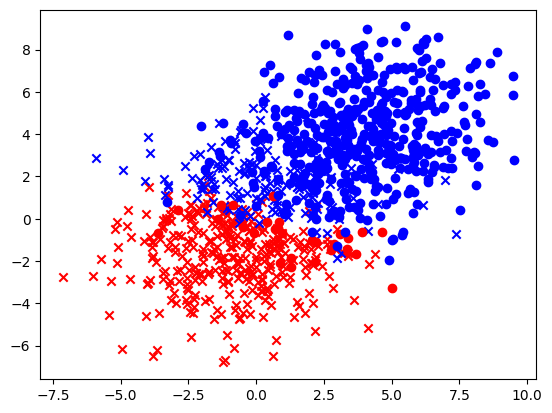

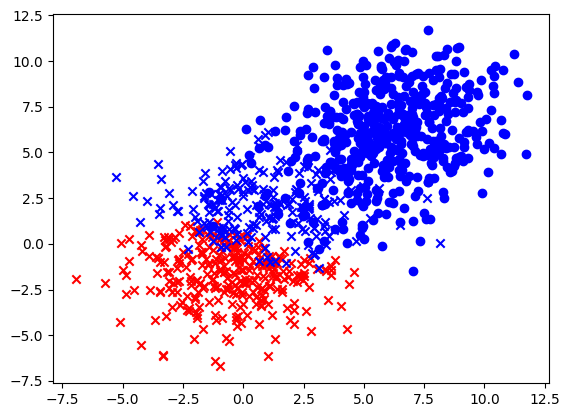

In [11]:
steps = [0, 5, 9]

for i in steps:
    x_neg = x[s0 == 0, i, :].detach().cpu().numpy()
    y_neg = y[s0 == 0, i, :].detach().cpu().numpy()
    y_neg = y_neg.squeeze()
    x_pos = x[s0 == 1, i, :].detach().cpu().numpy()
    y_pos = y[s0 == 1, i, :].detach().cpu().numpy()
    y_pos = y_pos.squeeze()

    plt.scatter(x_neg[y_neg==0, 0], x_neg[y_neg==0, 1], marker='x', color='red')
    plt.scatter(x_neg[y_neg==1, 0], x_neg[y_neg==1, 1], marker='x', color='blue')
    plt.scatter(x_pos[y_pos==0, 0], x_pos[y_pos==0, 1], marker='o', color='red')
    plt.scatter(x_pos[y_pos==1, 0], x_pos[y_pos==1, 1], marker='o', color='blue')
    plt.show()

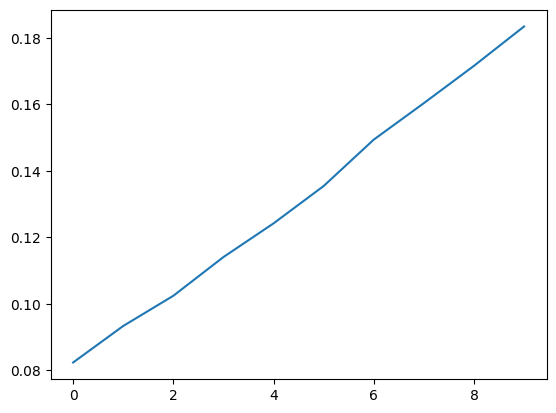

In [12]:
f_og = []
s_og = tensor(s0).view(len(s0), 1)
data = torch.empty(len(s0), seq_len, x0.shape[1] + 2)
for i in range(seq_len):
    x_og = x[:, i, :]
    y_og = y[:, i, :]
    data[:, i] = torch.cat([s_og.to(device), x_og.to(device), y_og.to(device)], dim=1)
    distance = compute_distance_loss(data[:, i].to(device))
    f_og.append(distance.item())

plt.plot(f_og)

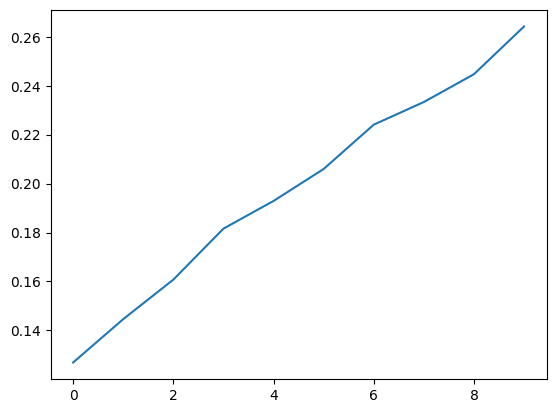

In [13]:
s_test = s_og[349:449, :]
x_test = x[349:449, :, :]
y_test = y[349:449, :, :]
data_test = data[349:449, :, :]
f_test_og = []
for i in range(seq_len):
    distance = compute_distance_loss(data_test[:, i].to(device))
    f_test_og.append(distance.item())

plt.plot(f_test_og)

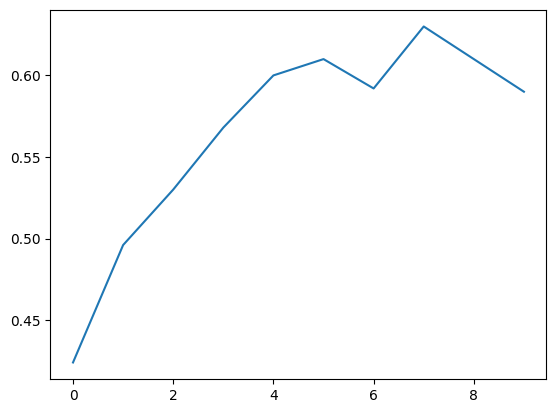

In [14]:
prob_diff = []
y_reshaped = y.view(n, seq_len, 1)
for i in range(seq_len):
    y_pos = y_reshaped[s0.squeeze() == 1, i, :]
    y_neg = y_reshaped[s0.squeeze() == 0, i, :]
    p_pos = torch.mean(y_pos)
    p_neg = torch.mean(y_neg)
    prob_diff.append(torch.abs(p_pos - p_neg).item())

plt.plot(prob_diff)

In [15]:
x = x.detach().numpy()
y = y.detach().numpy()
y = y.astype(int)
s0 = np.array(s0).reshape(len(s0),1)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(x_train.shape)


(700, 10, 2)


In [16]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(device).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
    
class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [17]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)
clf = Classifier(c_hiddens, dropout_prob=0.2)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): ReLU(inplace=True)
    (8): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [18]:
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset


def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss, loss2

#@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()
    hist_mmt = np.empty(0)

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, seq, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, seq-1, dim).to(device)
            s_mb = s_mb.to(device)
            y_mb = y_mb.to(device)

            for _ in range(2):
                g_loss, mmt_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)
                hist_mmt = np.append(hist_mmt, float(mmt_loss))

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f} | mmt_loss: {mmt_loss:6.4f}')

    hist_mmt = np.asarray(hist_mmt)
    plt.plot(np.arange(0, len(hist_mmt), 1), hist_mmt)
    # plt.plot(np.arange(0, len(hist_mmt) + 1, 1), np.arange(0, len(hist_mmt) + 1, 1))

def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [19]:
train_data = TensorDataset(tensor(s_train).to(device), tensor(x_train).to(device), tensor(y_train).to(device))
valid_data = TensorDataset(tensor(s_valid).to(device), tensor(x_valid).to(device),tensor(y_valid).to(device))
test_data = TensorDataset(tensor(s_test).to(device), tensor(x_test).to(device), tensor(y_test).to(device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [20]:
# clf.cuda()
if clf_path.exists():
    clf.load_state_dict(torch.load(clf_path, map_location=device))
else:
    clf.fit(train_loader, valid_loader, clf_path, device)
    torch.save(clf.state_dict(), clf_path)

In [21]:
clf.eval(test_loader, device)

20.16490203142166

In [22]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, unfair_clf.to(device), generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

In [23]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, unfair_clf.to(device), generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, unfair_clf.to(device), generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, unfair_clf.to(device), generator, device)

In [24]:
x_vars = gen_train_x[:,:,0]
z_vars = gen_train_x[:,:,1]
y_vars = gen_train_y[:, :, 0]

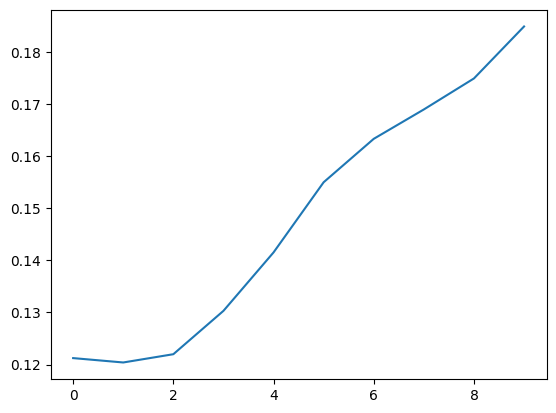

In [25]:
f_gan = []
for i in range(seq_len):
    y_gan = gen_test_y[:, i, 0]
    x_gan = gen_test_x[:, i, :]
    gan_test_data = torch.cat([tensor(gen_test_s), tensor(x_gan), tensor(y_gan).view(len(y_gan), 1)], dim=1)
    distance = compute_distance_loss(gan_test_data.to(device))
    f_gan.append(distance.item())

plt.plot(f_gan)

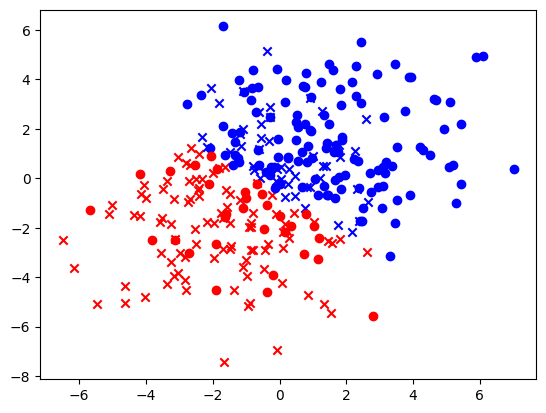

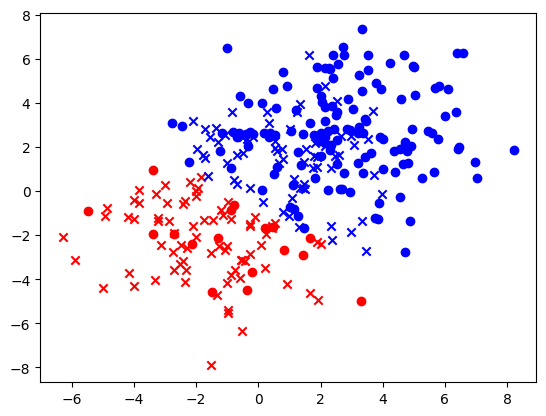

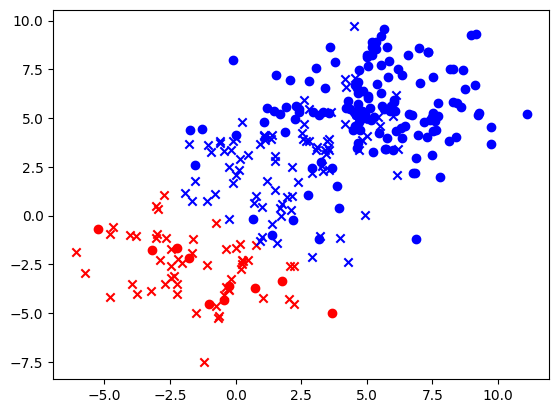

In [26]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][0])
        z11.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][0])
        z01.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][0])
        z10.append(z_vars[i][0])
    else:
        x00.append(x_vars[i][0])
        z00.append(z_vars[i][0])

fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
ax.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
ax.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
ax.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][3])
        z11.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][3])
        z01.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][3])
        z10.append(z_vars[i][3])
    else:
        x00.append(x_vars[i][3])
        z00.append(z_vars[i][3])

fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axm.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axm.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axm.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][9])
        z11.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][9])
        z01.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][9])
        z10.append(z_vars[i][9])
    else:
        x00.append(x_vars[i][9])
        z00.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

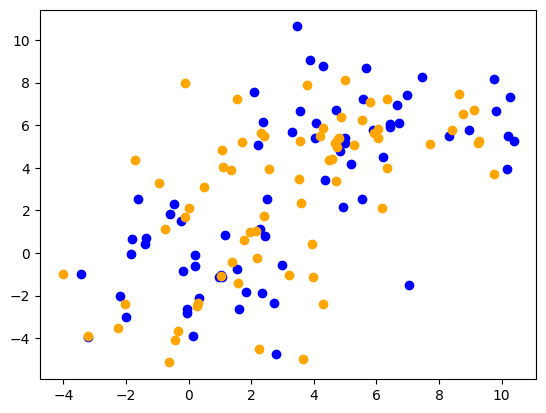

In [27]:
x_real_f = []
z_real_f = []

for i in range(70):
    x_real_f.append(x_train[i][9][0])
    z_real_f.append(x_train[i][9][1])

x_gan_f = []
z_gan_f = []
for i in range(70):
    x_gan_f.append(x_vars[i][9])
    z_gan_f.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_gan_f, z_gan_f, color = 'orange')

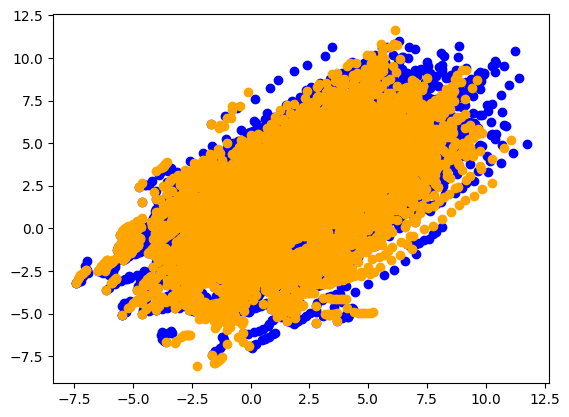

In [28]:
x_real_f = x_train[:, :, 0]
z_real_f = x_train[:, :, 1]

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_vars, z_vars, color = 'orange')

In [29]:
pairs = np.empty((0, 7))

for i in range(x.shape[0]):
    temp_pair = np.empty((1, 5 + 2*(x.shape[2] - 1)))
    temp_pair[0, 0] = s0[i]
    for j in range(x.shape[1] - 1):
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 1+k] = x[i, j, k]
        temp_pair[0, 1+x.shape[2]] = y[i, j][0]
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 2 + x.shape[2] + k] = x[i, j+1, k]
        temp_pair[0, 5 + 2*(x.shape[2] - 1) - 1] = y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])

print(len(pairs))
pairs = np.random.permutation(pairs)

9000


In [30]:
# separate generated training data into sequential step-wise pairs i.e. t0-t1, t1-t2, t2-t3, etc.
steps = np.empty((0, int(x_dim + 2)))

for i in range(x.shape[1]):
    temp_step = np.concatenate((gen_train_s, gen_train_x[:, i, :], gen_train_y[:, i, :]), axis=1)
    steps = np.append(steps, temp_step, axis=0)

print(len(steps))

7000


In [31]:
import pandas as pd

df = pd.DataFrame(pairs)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')


In [32]:
import os
from datasets.toy import ToySCM
from datasets.taiwan import TaiwanSCM
from models.vaca import VACA
import utils.args_parser  as argtools
from data_modules.het_scm import HeterogeneousSCMDataModule

scm = ToySCM(None, 'train', len(pairs))
model_file = os.path.join('_params', 'model_vaca.yaml')
trainer_file = os.path.join('_params', 'trainer.yaml')

cfg = argtools.parse_args(model_file)
cfg.update(argtools.parse_args(trainer_file))

cfg['dataset'] = {
    'name': 'toy',
    'params1': {},
    'params2': {}
}

cfg['dataset']['params1']['batch_size'] = batch_size
cfg['dataset']['params1']['num_samples_tr'] = len(steps)
cfg['dataset']['params1']['num_workers'] = 0
cfg['dataset']['params1']['equations_type'] = 'non-linear'
cfg['dataset']['params1']['normalize'] = 'lik'
cfg['dataset']['params1']['lambda_'] = 0.05
cfg['dataset']['params1']['data_dir'] = '../Data'
cfg['dataset']['params1']['device'] = device
cfg['dataset']['params1']['dataset_name'] = 'toy'

dataset_params = cfg['dataset']['params1']
data_module = HeterogeneousSCMDataModule(**dataset_params)

data_module.train_dataset._create_data()
data_module.valid_dataset._create_data()
data_module.test_dataset._create_data()
data_module.prepare_data()
data_module.train_dataloader()
data_module.test_dataloader()
data_module.val_dataloader()


cfg['model']['params']['is_heterogeneous'] = scm.is_heterogeneous
cfg['model']['params']['likelihood_x'] = scm.likelihood_list

cfg['model']['params']['num_nodes'] = scm.num_nodes
cfg['model']['params']['edge_dim'] = scm.edge_dimension

model_params = cfg['model']['params']

model_vaca = VACA(**model_params)
model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())

model_vaca.set_optim_params(optim_params=cfg['optimizer'],
                            sched_params=cfg['scheduler'])

In [33]:
from models._evaluator import MyEvaluator

evaluator = MyEvaluator(model=model_vaca,
                        intervention_list=data_module.train_dataset.get_intervention_list(),
                        scaler=data_module.scaler
                        )
model_vaca.set_my_evaluator(evaluator=evaluator)

assert evaluator is not None
is_training = train_vaca
del cfg['trainer']['progress_bar_refresh_rate']
del cfg['trainer']['flush_logs_every_n_steps']
del cfg['trainer']['terminate_on_nan']
del cfg['trainer']['auto_select_gpus']
del cfg['trainer']['weights_summary']
cfg['trainer']['enable_model_summary'] = False
del cfg['trainer']['gpus']
del cfg['trainer']['track_grad_norm']


In [34]:
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

yaml_file = ''
if yaml_file == '':
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed'])))
else:
        save_dir = os.path.join(yaml_file.split('/')[:-1])
print(f'Save dir: {save_dir}')
# trainer = pl.Trainer(**cfg['model'])
logger = TensorBoardLogger(save_dir=save_dir, name='logs', default_hp_metric=False)
out = logger.log_hyperparams(argtools.flatten_cfg(cfg))

save_dir_ckpt = argtools.mkdir(os.path.join(save_dir, 'ckpt'))
ckpt_file = argtools.newest(save_dir_ckpt)
callbacks = []
if is_training == 1:
    
    checkpoint = ModelCheckpoint(monitor=model_vaca.monitor(),
                                     mode=model_vaca.monitor_mode(),
                                     save_top_k=1,
                                     save_last=True,
                                     filename='checkpoint-{epoch:02d}',
                                     dirpath=save_dir_ckpt)

    callbacks = [checkpoint]

    if cfg['early_stopping']:
            early_stopping = EarlyStopping(model_vaca.monitor(), mode=model_vaca.monitor_mode(), min_delta=0.0,
                                           patience=50)
            callbacks.append(early_stopping)

    if ckpt_file is not None:
            print(f'Loading model training: {ckpt_file}')
            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='gpu')
    else:

            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='gpu')

    trainer.fit(model=model_vaca, datamodule=data_module)
    trainer.validate(ckpt_path=ckpt_file, dataloaders=data_module.val_dataloader())
    trainer.test(ckpt_path=ckpt_file, dataloaders=data_module.test_dataloader())
    argtools.save_yaml(cfg, file_path=os.path.join(save_dir, 'hparams_full.yaml'))
    
else:
        model_vaca = VACA.load_from_checkpoint(ckpt_file, **model_params)

Save dir: exper_test_10pct_noise/toy_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_7_21/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9


In [35]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [36]:

evaluator.set_model(model_vaca)
model_vaca.set_my_evaluator(evaluator=evaluator)


In [37]:
model_parameters = filter(lambda p: p.requires_grad, model_vaca.parameters())
params = int(sum([np.prod(p.size()) for p in model_parameters]))
model_vaca.eval()
model_vaca.freeze()

In [38]:
def p_to_csv(s, x, y, dataset):
    if isinstance(s, torch.Tensor):
        s = s.cpu().detach().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().detach().numpy()
    
    if dataset == 'toy':
        pairs = np.empty((0, 7))
        for i in range(x.shape[0]):
            temp = np.empty((1, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])
        df = pd.DataFrame(pairs)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        return pairs
    elif dataset == 'taiwan':
        pairs = np.empty((0, 7))
        for i in range(x.shape[0]):
            temp = np.empty((0, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])

        df = pd.DataFrame(pairs)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')    
        return pairs                     
        


In [39]:
def vaca_dataset(batch_size, pairs, device, dataset):
    model_file = os.path.join('_params', 'model_vaca.yaml')

    cfg = argtools.parse_args(model_file)    
    cfg['dataset'] = {
        'name': dataset,
        'params1': {},
        'params2': {}
    }

    cfg['dataset']['params1']['batch_size'] = batch_size
    cfg['dataset']['params1']['num_samples_tr'] = len(pairs)
    cfg['dataset']['params1']['num_workers'] = 0
    cfg['dataset']['params1']['equations_type'] = 'non-linear'
    cfg['dataset']['params1']['normalize'] = 'lik'
    cfg['dataset']['params1']['lambda_'] = 0.05
    cfg['dataset']['params1']['data_dir'] = '../Data'
    cfg['dataset']['params1']['device'] = device
    cfg['dataset']['params1']['dataset_name'] = dataset

    dataset_params = cfg['dataset']['params1']
    data_module = HeterogeneousSCMDataModule(**dataset_params)

    data_module.train_dataset._create_data()
    data_module.valid_dataset._create_data()
    data_module.test_dataset._create_data()
    data_module.total_dataset._create_data()
    data_module.prepare_data()
    data_module.train_dataloader()
    data_module.test_dataloader()
    data_module.val_dataloader()
    data_module.total_dataloader()
    return data_module

In [40]:

def intervention(nodes, values):
    inter = {}
    for i in range(len(nodes)):
        inter[nodes[i]] = values[i].item()
    return inter

def logistic(x):
    return torch.log(1 + torch.exp(x))


In [41]:
class Generator2(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(x0.device).scatter_(1, s0.long(), torch.ones_like(s0, device=x0.device))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round()
    

In [42]:
generator = Generator2(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
generator.load_state_dict(torch.load(gan_path, map_location=device))

<All keys matched successfully>

In [43]:
def intervention_step(loader, vaca, intervention_nodes, e, nodes, device):
    k = 0
    x_gan_input_list = []

    for batch in loader:
            batch.x_i = batch.x + e[k].to(batch.x.device).view(batch.x.shape)
            batch.x_i = batch.x_i.to(device)
            batch.x = batch.x.to(device)
            batch.edge_index = batch.edge_index.to(device)
            batch.edge_attr = batch.edge_attr.to(device)
            batch.edge_index_i = batch.edge_index_i.to(device)
            batch.edge_attr_i = batch.edge_attr_i.to(device)
        
            z_f, _ = vaca.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr, return_mean=True, node_ids=batch.node_ids)
            z_cf_I, _ = vaca.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,return_mean=True, node_ids=batch.node_ids)

            z_factual = z_f.reshape(1, -1)
            z_cf_I = z_cf_I.reshape(1, -1)

            z_dec = z_factual
            z_dim = vaca.z_dim

            for node_name in intervention_nodes:
                node_idx = loader.dataset.nodes_list.index(node_name)
                z_dec[:, z_dim * node_idx:z_dim * (node_idx + 1)] = z_cf_I[:, z_dim * node_idx: z_dim * (node_idx + 1)]

            z_dec = z_dec.reshape(-1, z_dim)

            x_CF, px_z = vaca.model.decoder(z_dec, batch.edge_index_i, edge_attr=batch.edge_attr_i, return_type='mean',  node_ids=batch.node_ids)
            adj = []
            for i in range(max(x_CF.shape)):
                if type(px_z.distributions[i]) == torch.distributions.normal.Normal:
                    adj.append(px_z.distributions[i].stddev)
                else:
                    adj.append(torch.tensor(0))

            x_CF+=(torch.tensor(adj, device=device)*torch.randn_like(x_CF, device=device))

            # x_CF = x_CF.view(len(nodes), -1)
            x_CF = x_CF[0]
            x_step =  x_CF[-int(len(nodes)/2):-1]


            x_gan_input_list.append(x_step.clone())

            k+=1
            if k == len(loader):
                break

    x_gan_input = torch.stack(x_gan_input_list, dim=0)


    return x_gan_input

In [54]:
def intervene(datamodule, loader, vaca, generator, clf, efforts, seq_len, dataset, device):
    nodes = datamodule.train_dataset.nodes_list
    intervention_nodes = datamodule.train_dataset.nodes_to_intervene
    # _inter = intervention(intervention_nodes, efforts[0])
    s = tensor(loader.dataset.X[:,0]).view(len(loader.dataset), 1).to(device)
    y_pred = torch.empty(len(loader), 0).to(device)
    y_pred.requires_grad_(True)
    datamodule.batch_size = 1
    x_post_int = torch.empty(len(loader), seq_len, int(len(nodes)/2-1)).to(device)
    x_post_int[:, 0, :] = tensor(loader.dataset.X[:, 1:int(len(nodes)/2)]).clone().to(device)
    inter_index = []
    for n in range(len(nodes)):
        if nodes[n] in intervention_nodes:
            inter_index.append(n)

    t = torch.empty(len(loader), 0)
    for ns in inter_index:
        t = torch.cat([t, torch.ones((len(loader),1))*ns], dim=1)

    t = t.type(torch.int64)

    t = t.to(device)
    efforts = efforts.to(device)
    
    for i in range(0, seq_len-1):
        
        e = torch.zeros((len(loader), len(nodes))).to(device).scatter(1, t, efforts.view(len(loader), seq_len-1, len(intervention_nodes))[:, i, :]).to(device)

        datamodule.batch_size = 1

        x_gan_input = intervention_step(loader, vaca, intervention_nodes, e, nodes, device)

        z_mb = torch.randn(len(loader), 1, int(len(nodes)/2)-1)

        gen_x_mb, _, gen_y_mb = generator(x_gan_input.view(len(loader), int(len(nodes)/2)-1).to(device), z_mb.to(device), s.reshape(len(loader),1).to(device), clf.to(device))
        y_pred = torch.cat([y_pred, gen_y_mb[:,0].to(device)], 1)

        x_next_steps = gen_x_mb[:, -2:, :]
        y_next_steps = gen_y_mb[:, -2:, :]
        x_post_int[:, i, :] = gen_x_mb[:, 0, :].clone()

        data = torch.cat([s.to(device), x_post_int[:, i, :].to(device), gen_y_mb[:,0].to(device)], 1)
        
        p_to_csv(s, x_next_steps, y_next_steps, dataset)

        datamodule = vaca_dataset(1, y_next_steps, device, dataset)
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'x2': 0, 'z2': 0})
        loader.dataset.set_intervention({'x2': 0, 'z2': 0})

    return y_pred, x_post_int, data


In [45]:
class effortNN(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortNN, self).__init__()
        self.fc1 = nn.Linear(int(datamodule.num_nodes), 128, bias=True, device=device)
        self.fc2 = nn.Linear(128, 64, bias=True, device=device)
        self.fc3 = nn.Linear(64, int(len(datamodule.train_dataset.nodes_to_intervene) * int(seq_len-1)), device=device)
        layers = []
        layers.append(self.fc1)
        layers.append(self.fc2)
        layers.append(self.fc3)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        efforts = self.fc3(x)

        return efforts
    

def budget_penalty(efforts, total_budget):
    b_loss = 0
    for i in range(efforts.shape[0]):
        b_loss += torch.relu(torch.sum(torch.abs(efforts[i])) - total_budget)
    return b_loss

def total_loss(efforts, total_budget, improvement_loss):
    budget_loss = budget_penalty(efforts, total_budget)
    t_loss = 100000*budget_loss + improvement_loss
    return t_loss

In [46]:
def compute_st_loss(s, y_pred):
    st_loss = 0.0
    for i in range(y_pred.shape[1]):
        y_neg = y_pred[s.squeeze() == 0, i]
        y_pos = y_pred[s.squeeze() == 1, i]
        p_y_pos = torch.sum(y_pos >= 0.5) / len(y_pos)
        p_y_neg = torch.sum(y_neg >= 0.5) / len(y_neg)
        st_loss += torch.abs(p_y_pos - p_y_neg)

    return st_loss/y_pred.shape[1]

def compute_post_long_cond_probs(s, Xs, Ys, clf):
    probs = {}
    
    for i in range(len(Xs)-1):
        
        XXs_comb = np.c_[s[s == 1], Xs[i][s == 1], Xs[i+1][s == 1]]
        Xs_comb = np.c_[s[s == 1], Xs[i][s == 1]]
        lr_up = LogisticRegression(random_state=2021).fit(XXs_comb, Ys[i][s == 1])
        lr_dn = LogisticRegression(random_state=2021).fit(Xs_comb, Ys[i][s == 1])
        probs_up = lr_up.predict_proba(XXs_comb)
        probs_dn = lr_dn.predict_proba(Xs_comb)
        probs[f'pos(y{i+1}=0)'] = probs_up[:, 0] / probs_dn[:, 0]
        probs[f'pos(y{i+1}=1)'] = probs_up[:, 1] / probs_dn[:, 1]


        XXs_comb = np.c_[s[s == 0], Xs[i][s == 0], Xs[i+1][s == 0]]
        Xs_comb = np.c_[s[s == 0], Xs[i][s == 0]]
        lr_up = LogisticRegression(random_state=2021).fit(XXs_comb, Ys[i][s == 0])
        lr_dn = LogisticRegression(random_state=2021).fit(Xs_comb, Ys[i][s == 0])
        probs_up = lr_up.predict_proba(XXs_comb)
        probs_dn = lr_dn.predict_proba(Xs_comb)
        probs[f'neg(y{i+1}=0)'] = probs_up[:, 0] / probs_dn[:, 0]
        probs[f'neg(y{i+1}=1)'] = probs_up[:, 1] / probs_dn[:, 1]
    return probs

def compute_lt_loss(s, y_pred, y0):

    y_neg = y_pred[(s.squeeze() == 0) & (y0.squeeze() == 0), -1]
    y_pos = y_pred[(s.squeeze() == 1) & (y0.squeeze() == 0), -1]
    p_y_neg = torch.sum(y_neg >= 0.5) / len(y_neg)
    p_y_pos = torch.sum(y_pos >= 0.5) / len(y_pos)
    lt_loss = torch.abs(p_y_pos - p_y_neg)
    
    return lt_loss

In [47]:
data_module = vaca_dataset(batch_size, steps, device, dataset='toy')
original_pairs = data_module.total_dataloader().dataset.X
t0 = original_pairs[:len(steps), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, dataset='toy')

In [48]:
class effortLSTM(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortLSTM, self).__init__()

        self.seq_len = seq_len-1
        self.num_interventions = len(datamodule.train_dataset.nodes_to_intervene)
        self.hidden_size = 128

        self.lstm = nn.LSTM(int((datamodule.num_nodes)), self.hidden_size, num_layers=2, batch_first=True)

        self.fc = nn.Linear(self.hidden_size, self.num_interventions)

        self.to(device)

    def forward(self, x):

        batch_size = x.size(0)
        h_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)

        efforts_seq = []
        
        for _ in range(seq_len):
            lstm_out, (h_0, c_0) = self.lstm(x, (h_0, c_0))
            efforts = self.fc(lstm_out)
            efforts_seq.append(efforts)

        efforts_seq = torch.stack(efforts_seq, dim=1)

        return efforts_seq
    
class effortLSTM_clf(nn.Module):
    def __init__(self, datamodule, seq_len, clf, device):
        super(effortLSTM_clf, self).__init__()

        self.seq_len = seq_len-1
        self.num_interventions = len(datamodule.train_dataset.nodes_to_intervene)
        self.hidden_size = 128
        self.clf = clf

        for param in self.clf.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(int((datamodule.num_nodes)), self.hidden_size, num_layers=2, batch_first=True)

        self.fc = nn.Linear(self.hidden_size, self.num_interventions)

        self.to(device)

    def forward(self, x):

        s0 = x[:, 0, 0].view(x.size(0), 1)

        batch_size = x.size(0)
        
        clf_outputs = self.clf(s0, x[:, 0, -3:-1])
        
        x_with_y = torch.cat([x[:,0,:-1], clf_outputs.view(batch_size,1)], dim=1)
        h_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)

        efforts_seq = []
        
        for _ in range(seq_len):
            clf_outputs = self.clf(s0, x[:, 0, -3:-1])
            x_with_y = torch.cat([x[:,0,:-1], clf_outputs.view(batch_size,1)], dim=1).unsqueeze(1)
            lstm_out, (h_0, c_0) = self.lstm(x_with_y, (h_0, c_0))
            efforts = self.fc(lstm_out.squeeze(1))
            efforts_seq.append(efforts)

        efforts_seq = torch.stack(efforts_seq, dim=1)

        return efforts_seq

## Training

In [ ]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*0.7), :]
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortNN(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [1, 2]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('steps.csv')
    data_module = vaca_dataset(1, t0, device, 'toy')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortNN(data_module, loader, seq_len, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    efforts_path = log_dir / (f"effort_model" + "_budget_" + str(budget) + ".pth")
    best_loss = float('inf')
    patience = 0

    hist_loss = []

    for epoch in range(100):
        epoch_start = time.time()
        efforts = net(tensor(loader.dataset.X).to(device))
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))

        lt_fairness = compute_distance_loss(data)
        t_loss = 10000*budget_penalty(efforts, budget*.95) + lt_fairness + 0.1*improvement_loss
        
        t_loss.backward()
        
        optimizer.step()
        df = pd.DataFrame(original_data)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        epoch_end = time.time()
        hist_loss.append(t_loss.item())
        
        if t_loss < best_loss:
            best_loss = t_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            e = epoch
        
        else:
            patience += 1
            if (patience > 20 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f}')

    print('Last saved epoch: ', e)

    plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
    plt.show()


Epoch:    0 | Total Loss:  4997404.0000 | Budget Loss:  4997404.00 | Long Fairness Loss:  0.0702 | Improvement Loss:  0.5412 | Time:  111.6


In [53]:
efforts.view(len(loader), seq_len-1, len(data_module.train_dataset.nodes_to_intervene)).shape

torch.Size([489, 9, 2])

Epoch:    0 | Total Loss:  9770630.0000 | Budget Loss:  9770630.00 | Long Fairness Loss:  0.0498 | Time:  150.7
Epoch:   10 | Total Loss:  2252462.2500 | Budget Loss:  2252462.25 | Long Fairness Loss:  0.0490 | Time:  150.6
Epoch:   20 | Total Loss:  124056.9453 | Budget Loss:  124056.84 | Long Fairness Loss:  0.0514 | Time:  151.4
Epoch:   30 | Total Loss:  7410.3433 | Budget Loss:  7410.24 | Long Fairness Loss:  0.0516 | Time:  151.9
Epoch:   40 | Total Loss:   0.0996 | Budget Loss:  0.00 | Long Fairness Loss:  0.0498 | Time:  153.3
Early stopping
 Last save: 39
Last saved epoch:  39


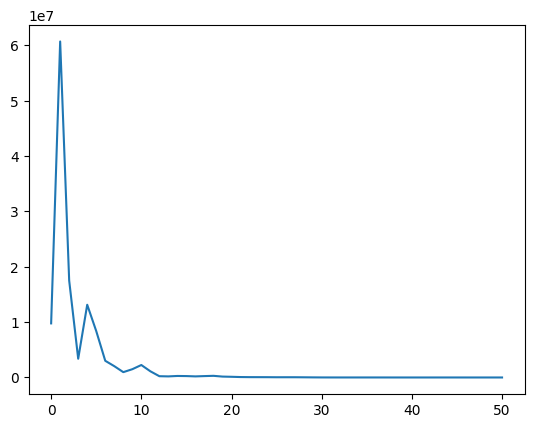

In [87]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*.7), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device)
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortNN(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
best_loss = float('inf')
patience = 0

hist_loss = []
b_list = [0.2, 0.4, 0.5, 0.8, 1]
budget = 0.1*seq_len
efforts_path = log_dir / (f"effort_model" + "_budget_" + str(budget) + ".pth")

for epoch in range(100):
    epoch_start = time.time()
    efforts = net(tensor(loader.dataset.X).to(device))
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
    improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
    st_fairness = compute_st_loss(s, y_hat)
    lt_fairness = compute_distance_loss(data)
    t_loss = 10000*budget_penalty(efforts, budget*.95) + 2*lt_fairness + 0.1*improvement_loss + 0.1*st_fairness
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    df = pd.DataFrame(original_data)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('pairs.csv')
    epoch_end = time.time()
    hist_loss.append(t_loss.item())
    if t_loss < best_loss:
        best_loss = t_loss
        patience = 0
        torch.save(net.state_dict(), efforts_path)
        e = epoch
        
    
    else:
        patience += 1
        if (patience > 10 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
            print('Early stopping')
            print(f' Last save: {e}')
            break

    if epoch % 10 == 0:
        print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} Time: {epoch_end - epoch_start: 3.1f}')

print('Last saved epoch: ', e)

plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
plt.show()


In [98]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device, 'toy')
original_pairs = data_module.total_dataloader().dataset.X

In [51]:
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortNN(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_path = log_dir / (f"effort_model" + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.1*improvement_loss + lt_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [49]:
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = 20')
plt.legend()
plt.savefig(f'Fairness plot Budget = 20.png')
plt.show()


NameError: name 'loader' is not defined

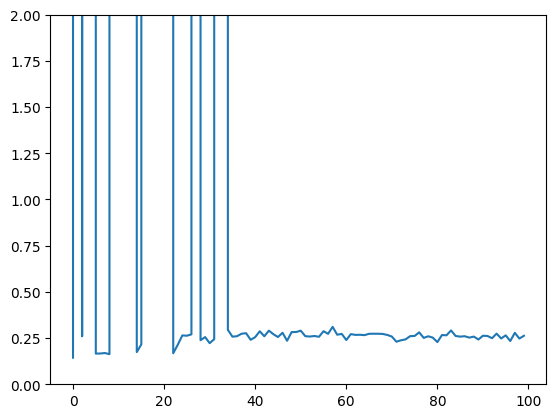

In [54]:
plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
plt.ylim(0, 2)
plt.show()

Epoch:    0 | Total Loss:   0.1893 | Budget Loss:  0.00 | Long Fairness Loss:  0.0793 | Improvement Loss:  0.5201 | Time:  119.3 | Patience: 0
Epoch:   10 | Total Loss:   0.2261 | Budget Loss:  0.00 | Long Fairness Loss:  0.0947 | Improvement Loss:  0.5562 | Time:  128.7 | Patience: 4
Epoch:   20 | Total Loss:   0.3847 | Budget Loss:  0.00 | Long Fairness Loss:  0.1672 | Improvement Loss:  0.4981 | Time:  131.6 | Patience: 14
Early stopping
 Last save: 6
Last saved epoch:  6


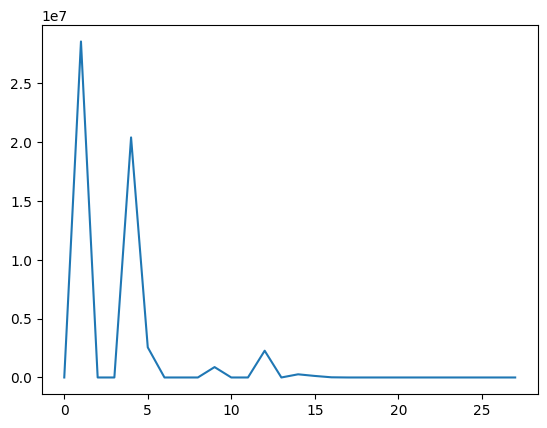

Epoch:    0 | Total Loss:   0.1594 | Budget Loss:  0.00 | Long Fairness Loss:  0.0658 | Improvement Loss:  0.4990 | Time:  131.6 | Patience: 0
Epoch:   10 | Total Loss:   0.2296 | Budget Loss:  0.00 | Long Fairness Loss:  0.0979 | Improvement Loss:  0.3792 | Time:  132.4 | Patience: 5
Epoch:   20 | Total Loss:   0.3395 | Budget Loss:  0.00 | Long Fairness Loss:  0.1458 | Improvement Loss:  0.5790 | Time:  135.1 | Patience: 15
Early stopping
 Last save: 5
Last saved epoch:  5


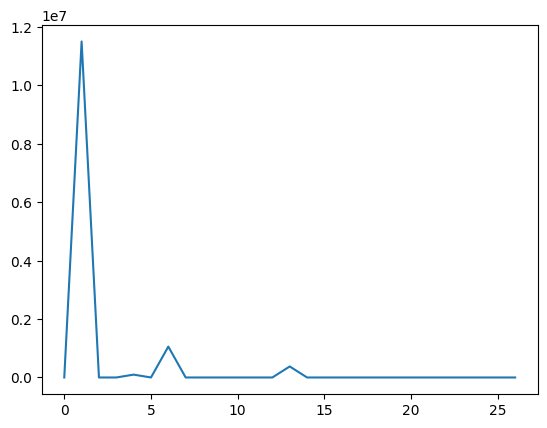

In [50]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*0.7), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, dataset='toy')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortLSTM(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [1, 2]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('steps.csv')
    data_module = vaca_dataset(1, t0, device, dataset='toy')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'x2': 0, 'z2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM(data_module, loader, seq_len, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.02)

    efforts_path = log_dir / (f"LSTM_effort_model_2layers" + "_budget_" + str(budget) + ".pth")
    best_loss = float('inf')
    patience = 0

    hist_loss = []

    for epoch in range(100):
        epoch_start = time.time()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len, 2), seq_len, 'toy', device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 10000*budget_penalty(efforts, budget*0.95) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness
        
        t_loss.backward()
        optimizer.step()
        df = pd.DataFrame(original_data)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        epoch_end = time.time()
        hist_loss.append(t_loss.item())
        if t_loss < best_loss:
            best_loss = t_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 20 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
    plt.show()


Epoch:    0 | Total Loss:   0.1583 | Budget Loss:  0.00 | Long Fairness Loss:  0.0654 | Improvement Loss:  0.5081 | Time:  134.0 | Patience: 0
Epoch:   10 | Total Loss:   0.1472 | Budget Loss:  0.00 | Long Fairness Loss:  0.0605 | Improvement Loss:  0.4763 | Time:  131.2 | Patience: 0
Epoch:   20 | Total Loss:   0.1860 | Budget Loss:  0.00 | Long Fairness Loss:  0.0781 | Improvement Loss:  0.4810 | Time:  132.2 | Patience: 7
Epoch:   30 | Total Loss:   0.2327 | Budget Loss:  0.00 | Long Fairness Loss:  0.0991 | Improvement Loss:  0.4851 | Time:  134.4 | Patience: 17
Early stopping
 Last save: 13
Last saved epoch:  13


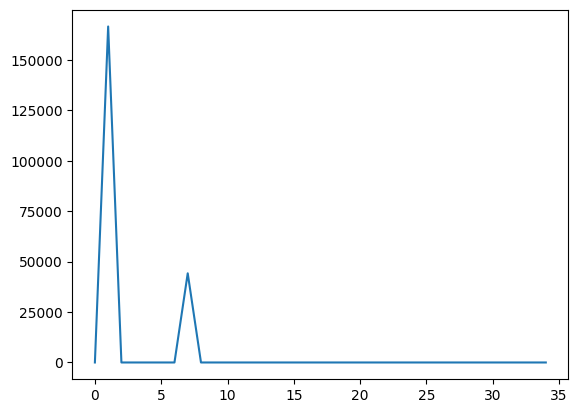

Epoch:    0 | Total Loss:   0.1550 | Budget Loss:  0.00 | Long Fairness Loss:  0.0653 | Improvement Loss:  0.4731 | Time:  134.6 | Patience: 0
Epoch:   10 | Total Loss:   0.1468 | Budget Loss:  0.00 | Long Fairness Loss:  0.0591 | Improvement Loss:  0.5290 | Time:  134.3 | Patience: 6
Epoch:   20 | Total Loss:   0.1526 | Budget Loss:  0.00 | Long Fairness Loss:  0.0616 | Improvement Loss:  0.5385 | Time:  134.2 | Patience: 2
Epoch:   30 | Total Loss:   0.1620 | Budget Loss:  0.00 | Long Fairness Loss:  0.0667 | Improvement Loss:  0.5571 | Time:  139.3 | Patience: 7
Epoch:   40 | Total Loss:   0.1600 | Budget Loss:  0.00 | Long Fairness Loss:  0.0638 | Improvement Loss:  0.5306 | Time:  140.7 | Patience: 17
Early stopping
 Last save: 23
Last saved epoch:  23


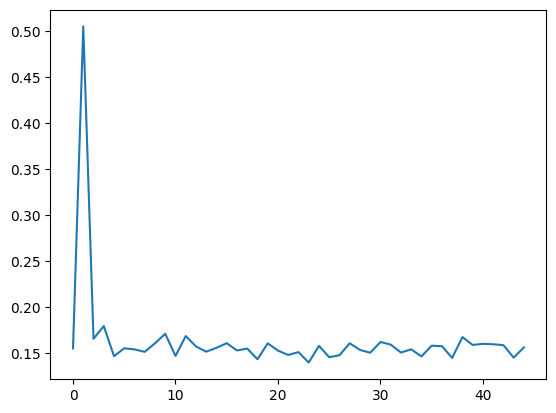

In [73]:
import time
original_data = data_module.total_dataloader().dataset.X
t0 = original_pairs[:int(n*0.7), :]
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('steps.csv')
data_module = vaca_dataset(1, t0, device, 'toy')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
loss_fn = torch.nn.MSELoss()
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [1, 2]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
    df.to_csv('steps.csv')
    data_module = vaca_dataset(1, t0, device, 'toy')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    efforts_path = log_dir / (f"LSTM_clf_effort_model_" + "_budget_" + str(budget) + ".pth")
    best_loss = float('inf')
    patience = 0

    hist_loss = []

    for epoch in range(100):
        epoch_start = time.time()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len, 2), seq_len, 'toy', device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 10000*budget_penalty(efforts, budget*0.95) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness
        
        t_loss.backward()
        optimizer.step()
        df = pd.DataFrame(original_data)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        epoch_end = time.time()
        hist_loss.append(t_loss.item())
        if t_loss < best_loss:
            best_loss = t_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 20 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
    plt.show()


In [ ]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_effort_model" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



NameError: name 'effortLSTM' is not defined

In [80]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_clf_effort_model_" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



KeyboardInterrupt: 

In [49]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_effort_model" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



RuntimeError: Error(s) in loading state_dict for effortLSTM:
	Missing key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 

Positive Efforts: 0.14498406648635864
Negative Efforts: 0.1610255092382431


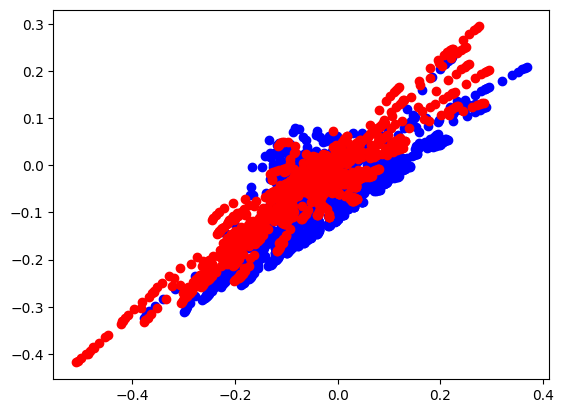

In [380]:
pos_efforts = efforts.view(len(loader), seq_len, 2)[s.squeeze() == 1, :].view(-1, 2)
neg_efforts = efforts.view(len(loader), seq_len, 2)[s.squeeze() == 0, :].view(-1, 2)
print(f'Positive Efforts: {torch.mean(torch.norm(pos_efforts, 2, dim=1), dim=0)}')
print(f'Negative Efforts: {torch.mean(torch.norm(neg_efforts, 2, dim=1), dim=0)}')
plt.scatter(pos_efforts[:,0].detach().cpu().numpy(), pos_efforts[:,1].detach().cpu().numpy(), color = 'blue')
plt.scatter(neg_efforts[:,0].detach().cpu().numpy(), neg_efforts[:,1].detach().cpu().numpy(), color = 'red')

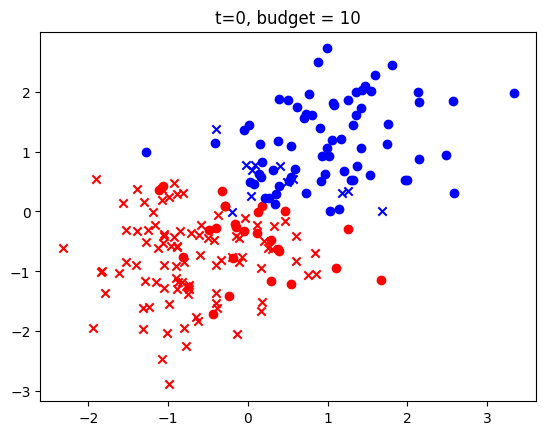

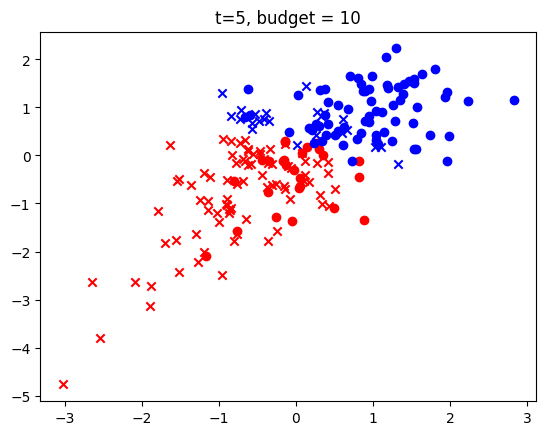

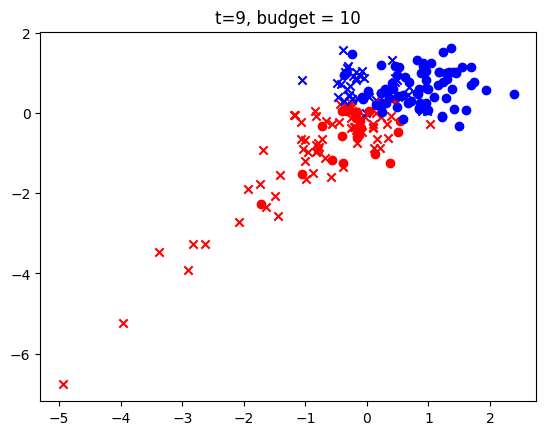

In [53]:
steps = [0, 5, 9]
x_hat_test = x_hat.detach().cpu().numpy()
y_hat_test = y_hat.detach().cpu().numpy()
s_test = s.detach().cpu().numpy()

for i in steps:
    x_neg = x_hat_test[s_test == 0, i, :]
    y_neg = y_hat_test[s_test == 0, i]
    y_neg = y_neg.squeeze()
    x_pos = x_hat_test[s_test == 1, i, :]
    y_pos = y_hat_test[s_test == 1, i]
    y_pos = y_pos.squeeze()

    plt.scatter(x_neg[y_neg==0, 0], x_neg[y_neg==0, 1], marker='x', color='red')
    plt.scatter(x_neg[y_neg==1, 0], x_neg[y_neg==1, 1], marker='x', color='blue')
    plt.scatter(x_pos[y_pos==0, 0], x_pos[y_pos==0, 1], marker='o', color='red')
    plt.scatter(x_pos[y_pos==1, 0], x_pos[y_pos==1, 1], marker='o', color='blue')
    plt.title(f't={i}, budget = {budget}')
    plt.savefig("t=" + str(i) + ", budget = " +str(budget) +".png")
    plt.show()

In [55]:
s_test

array([0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.], dtype=float32)

tensor([[0.0197, 0.0420],
        [0.0554, 0.0855],
        [0.0721, 0.1110],
        [0.0737, 0.1220],
        [0.0686, 0.1254],
        [0.0623, 0.1258],
        [0.0571, 0.1254],
        [0.0536, 0.1250],
        [0.0516, 0.1248],
        [0.0504, 0.1247]], device='cuda:0', grad_fn=<ViewBackward0>)

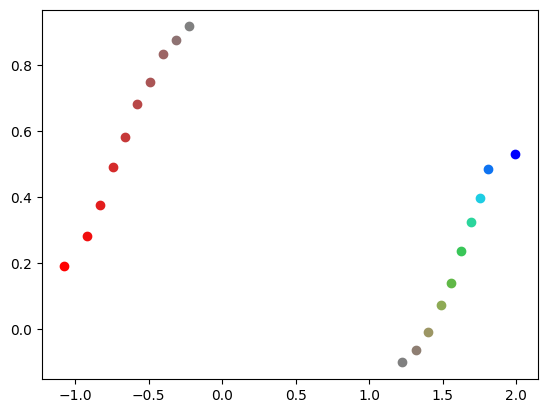

In [57]:
from colour import Color
red = Color("blue")
colors = list(red.range_to(Color("grey"), seq_len))
for i in range(seq_len):
    plt.scatter(x_hat_test[1, i,0], x_hat_test[1, i,1], color = colors[i].hex)

blue = Color("red")
colors = list(blue.range_to(Color("grey"), seq_len))
for i in range(seq_len):
    plt.scatter(x_hat_test[0, i,0], x_hat_test[0, i,1], color = colors[i].hex)
efforts[0].view(10,2)

## Testing

In [59]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
model_fairness_lstm_clf = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
n = 200
budget = 2*seq_len
efforts_lstm_clf = torch.empty(len(seeds), n, seq_len, 2)
efforts_path = log_dir / (f"LSTM_clf_effort_model_" + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
for seed in seeds:
    t1 = time.time()
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=seed)
    p_to_csv(s0.reshape(n,1), x[:, 0:2, :], y[:, 0:2, :], 'toy')
    og_data = torch.empty(n, seq_len, x_dim + 2)
    for i in range(seq_len):
        og_data[:, i] = torch.cat([tensor(s0.reshape(n, 1)), x[:,i, :], y[:, i, :]], dim=1).to(device)
        distance = compute_distance_loss(og_data[:, i].to(device))
        og_fairness[seed-2031, i] = distance.item()
    data_module = vaca_dataset(1, y, device, 'toy')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, 7).to(device))
    efforts_lstm_clf[seed-2031] = efforts.view(n, seq_len, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        distance = compute_distance_loss(data_t)
        model_fairness_lstm_clf[seed-2031, i+1] = distance.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

Seed: 2031 | Time:  50.38
Seed: 2032 | Time:  50.74
Seed: 2033 | Time:  49.46
Seed: 2034 | Time:  51.40
Seed: 2035 | Time:  50.87
Seed: 2036 | Time:  50.61
Seed: 2037 | Time:  50.27
Seed: 2038 | Time:  50.56
Seed: 2039 | Time:  49.43
Seed: 2040 | Time:  51.60
Seed: 2041 | Time:  51.19
Seed: 2042 | Time:  50.32
Seed: 2043 | Time:  49.37
Seed: 2044 | Time:  51.46
Seed: 2045 | Time:  49.60
Seed: 2046 | Time:  51.22
Seed: 2047 | Time:  50.41
Seed: 2048 | Time:  50.01
Seed: 2049 | Time:  50.40
Seed: 2050 | Time:  49.62
Seed: 2051 | Time:  46.82
Seed: 2052 | Time:  48.69
Seed: 2053 | Time:  49.63
Seed: 2054 | Time:  50.00
Seed: 2055 | Time:  49.37
Seed: 2056 | Time:  50.16
Seed: 2057 | Time:  47.47
Seed: 2058 | Time:  49.10
Seed: 2059 | Time:  48.06
Seed: 2060 | Time:  48.51


In [60]:
og_fairness_tl = np.mean(og_fairness, axis=0)
model_fairness_lstm_clf[:, 0] = og_fairness[:, 0]
model_fairness_tl_lstm_clf = np.mean(model_fairness_lstm_clf, axis=0)
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_top_lstm_clf = model_fairness_tl_lstm_clf + np.std(model_fairness_lstm_clf, axis=0)
model_bottom_lstm_clf = model_fairness_tl_lstm_clf - np.std(model_fairness_lstm_clf, axis=0)
model_fairness_tl_lstm_clf[0] = og_fairness_tl[0]
model_bottom_lstm_clf[0] = og_bottom[0]
model_top_lstm_clf[0] = og_top[0]


In [61]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
model_fairness_lstm = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
net = effortLSTM(data_module, loader, seq_len, device)
n = 200
budget = 2*seq_len
efforts_lstm = torch.empty(len(seeds), n, seq_len, 2)
efforts_path = log_dir / (f"LSTM_effort_model_2layers" + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
failed_flag = False
for seed in seeds:
    t1 = time.time()
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=seed)
    p_to_csv(s0.reshape(n,1), x[:, :2, :], y[:, :2, :], 'toy')
    og_data = torch.empty(n, seq_len, x_dim + 2)
    for i in range(seq_len):
        og_data[:, i] = torch.cat([tensor(s0.reshape(n, 1)), x[:,i, :], y[:, i, :]], dim=1).to(device)
        distance = compute_distance_loss(og_data[:, i].to(device))
        og_fairness[seed-2031, i] = distance.item()
    data_module = vaca_dataset(1, y, device, 'toy')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, 7).to(device))
    efforts_lstm[seed-2031] = efforts.view(n, seq_len, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        distance = compute_distance_loss(data_t)
        model_fairness_lstm[seed-2031, i+1] = distance.item()
        if torch.isnan(distance):
            print('Nan')
            print(distance)
            failed_data = data_t
            failed_flag = True
    if failed_flag:
        s_fail = data[:, 0]
        x_fail = x_hat
        y_fail = y_hat
        failed_flag = False

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

Seed: 2031 | Time:  49.96
Seed: 2032 | Time:  48.97
Seed: 2033 | Time:  48.68
Seed: 2034 | Time:  47.43
Seed: 2035 | Time:  47.49
Seed: 2036 | Time:  50.27
Seed: 2037 | Time:  48.36
Seed: 2038 | Time:  48.25
Seed: 2039 | Time:  49.15
Seed: 2040 | Time:  50.21
Seed: 2041 | Time:  49.95
Seed: 2042 | Time:  48.47
Seed: 2043 | Time:  48.96
Seed: 2044 | Time:  50.30
Seed: 2045 | Time:  47.88
Seed: 2046 | Time:  49.56
Seed: 2047 | Time:  47.29
Seed: 2048 | Time:  50.24
Seed: 2049 | Time:  50.96
Seed: 2050 | Time:  50.89
Seed: 2051 | Time:  49.27
Seed: 2052 | Time:  49.05
Seed: 2053 | Time:  51.37
Seed: 2054 | Time:  49.90
Seed: 2055 | Time:  51.07
Seed: 2056 | Time:  49.37
Seed: 2057 | Time:  50.93
Seed: 2058 | Time:  49.71
Seed: 2059 | Time:  50.97
Seed: 2060 | Time:  51.50


In [164]:
nan_indices = torch.isnan(failed_data).nonzero()
nan_indices


tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)

In [62]:
og_fairness_tl = np.mean(og_fairness, axis=0)
model_fairness_tl_lstm = np.mean(model_fairness_lstm, axis=0)
model_fairness_lstm[:, 0] = og_fairness[:, 0]
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_top_lstm = model_fairness_tl_lstm + np.std(model_fairness_lstm, axis=0)
model_bottom_lstm = model_fairness_tl_lstm - np.std(model_fairness_lstm, axis=0)
model_fairness_tl_lstm[0] = og_fairness_tl[0]
model_bottom_lstm[0] = og_bottom[0]
model_top_lstm[0] = og_top[0]


In [177]:
model_fairness_lstm[:, 0]

array([0.08258536, 0.08790653, 0.09958657, 0.07585779, 0.07864486,
       0.08949672, 0.07851639, 0.08651899, 0.08780497, 0.09986853,
       0.08186129, 0.08744872, 0.08331241, 0.09057395, 0.10795756,
       0.07247347, 0.09252056, 0.07656906, 0.07275988, 0.07158206,
       0.08687709, 0.07973806, 0.10016349, 0.07623306, 0.06193125,
       0.08870816, 0.06927446, 0.08052532, 0.07676969, 0.10107632])

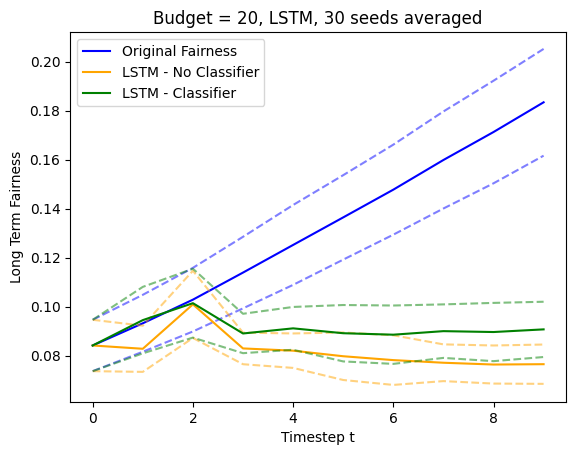

In [63]:
timeline = range(seq_len)
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='LSTM - No Classifier')
plt.plot(timeline, model_top_lstm_clf, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm_clf, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm_clf, color='green', label='LSTM - Classifier')
plt.title(f'Budget = {budget}, LSTM, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 3.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

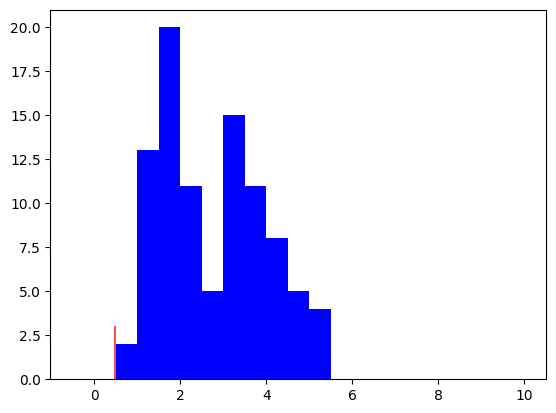

In [53]:
pos_efforts = efforts.view(n, seq_len, 2)[s0.squeeze() == 1, :]
ps = []
for i in range(len(pos_efforts)):
    ps.append(torch.sum(torch.abs(pos_efforts[i])).item())

plt.hist(ps, color='blue', range=(0, 10), bins=20)

neg_efforts = efforts.view(n, seq_len, 2)[s0.squeeze() == 0, :]
ns = []
for i in range(len(neg_efforts)):
    ns.append(torch.sum(torch.abs(neg_efforts[i])).item())

plt.hist(ns, color='red', alpha=0.7, range=(0, 0), bins=20)

In [64]:
seeds = list(range(2021, 2051))
n = 200
og_fairness = np.empty((len(seeds), seq_len))
model_fairness = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
net = effortNN(data_module, loader, seq_len, device)
budget = 2*seq_len
efforts_path = log_dir / (f"effort_model" + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
nn_efforts = torch.empty(len(seeds), n, seq_len, 2)
for seed in seeds:
    t1 = time.time()
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=seed)
    p_to_csv(s0.reshape(n,1), x[:, :2, :], y[:, :2, :], 'toy')
    og_data = torch.empty(n, seq_len, x_dim + 2)
    for i in range(seq_len):
        og_data[:, i] = torch.cat([tensor(s0.reshape(n, 1)), x[:,i, :], y[:, i, :]], dim=1).to(device)
        distance = compute_distance_loss(og_data[:, i].to(device))
        og_fairness[seed-2021, i] = distance.item()
    data_module = vaca_dataset(1, y, device, 'toy')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'x1': 0, 'z1': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).to(device))
    nn_efforts[seed-2021] = efforts.view(n, seq_len, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'toy', device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        distance = compute_distance_loss(data_t)
        model_fairness[seed-2021, i+1] = distance.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')

Seed: 2021 | Time:  50.88
Seed: 2022 | Time:  51.04
Seed: 2023 | Time:  49.48
Seed: 2024 | Time:  49.26
Seed: 2025 | Time:  50.04
Seed: 2026 | Time:  50.54
Seed: 2027 | Time:  50.17
Seed: 2028 | Time:  48.91
Seed: 2029 | Time:  50.02
Seed: 2030 | Time:  49.80
Seed: 2031 | Time:  50.38
Seed: 2032 | Time:  48.03
Seed: 2033 | Time:  50.57
Seed: 2034 | Time:  49.23
Seed: 2035 | Time:  50.68
Seed: 2036 | Time:  50.23
Seed: 2037 | Time:  49.81
Seed: 2038 | Time:  50.48
Seed: 2039 | Time:  50.45
Seed: 2040 | Time:  49.92
Seed: 2041 | Time:  50.27
Seed: 2042 | Time:  49.06
Seed: 2043 | Time:  50.32
Seed: 2044 | Time:  50.07
Seed: 2045 | Time:  49.81
Seed: 2046 | Time:  50.33
Seed: 2047 | Time:  51.25
Seed: 2048 | Time:  53.14
Seed: 2049 | Time:  51.94
Seed: 2050 | Time:  51.57


In [65]:
model_fairness[:, 0] = og_fairness[:, 0]
model_fairness_tl = np.mean(model_fairness, axis=0)

model_top = model_fairness_tl + np.std(model_fairness, axis=0)
model_bottom = model_fairness_tl - np.std(model_fairness, axis=0)
model_fairness_tl[0] = og_fairness_tl[0]
model_bottom[0] = og_bottom[0]
model_top[0] = og_top[0]

In [185]:
model_fairness[:, 1]

array([0.13151854, 0.01999979, 0.13269123,        nan, 0.00979725,
       0.00981665,        nan, 0.15044072, 0.15050945, 0.11313717,
       0.14673525, 0.12860802, 0.11271144, 0.00999997, 0.11753684,
       0.13282321, 0.12049422, 0.16000162,        nan,        nan,
       0.13355853, 0.00999997,        nan, 0.16254437, 0.00979093,
       0.00999997, 0.15648897, 0.13988714,        nan, 0.11683995])

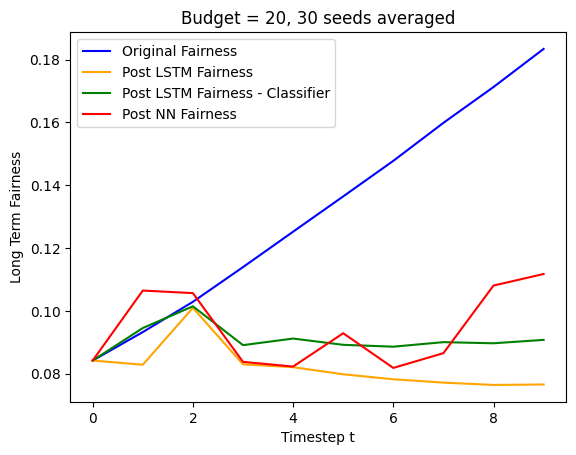

In [66]:
timeline = range(seq_len)
dataset = 'toy'
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness')
plt.plot(timeline, model_fairness_tl_lstm_clf, color='green', label='Post LSTM Fairness - Classifier')
plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')
plt.title(f'Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.savefig(str(dataset) + 'budget = ' + str(budget) + ' fairness_plot.png')
plt.show()

In [ ]:
timeline = range(seq_len)
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness')
plt.plot(timeline, model_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')
plt.title(f'Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

NameError: name 'og_top' is not defined

## Baseline WIP

In [72]:
from baseline import *

s0, x0, y0 = gen_gaussian(int(n/2), seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=52)
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

train_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[0:int(n*(1-test_size)), :]
test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[int(n*(1-test_size)):, :]

train_dataset = SimpleDataset(train_data[:, :-1], train_data[:, -1])
test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


Epoch 0 p_loss: 0.6448120176792145, f_loss: 0.05900391936302185
Epoch 10 p_loss: 0.7093051970005035, f_loss: 0.011312037706375122
Epoch 20 p_loss: 0.7205254435539246, f_loss: 0.017847001552581787
Epoch 30 p_loss: 0.698684960603714, f_loss: 0.028636813163757324
Epoch 40 p_loss: 0.7099922597408295, f_loss: 0.014920234680175781


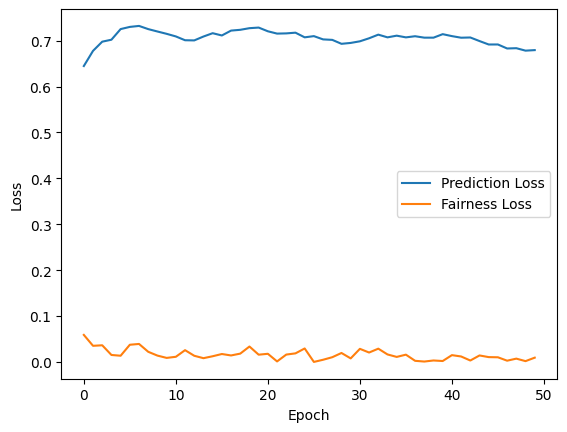

In [73]:
ei_model = trainer_fb_fair(model, train_loader, [1,2], optim, device, 50, 0.95)

Epoch 0 p_loss: 0.800753116607666, f_loss: 0.012789670377969742
Epoch 10 p_loss: 0.7154508233070374, f_loss: 0.0054138824343681335
Epoch 20 p_loss: 0.6628914326429367, f_loss: 0.002351272851228714
Epoch 30 p_loss: 0.6484779268503189, f_loss: 0.0022459514439105988
Epoch 40 p_loss: 0.6391743421554565, f_loss: 0.004856906831264496


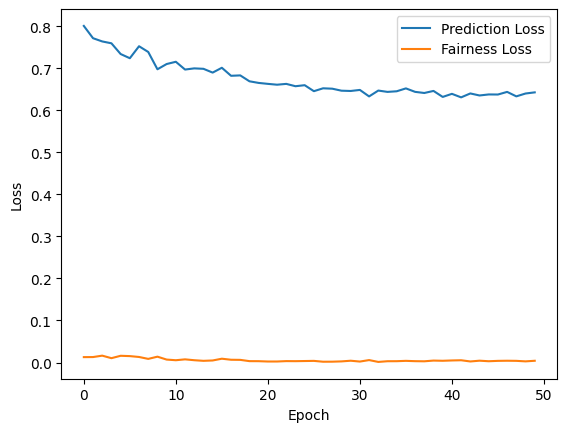

In [51]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
dp_model = trainer_dp_fair(model, train_loader, optim, device, 50, 0.95)

Epoch 0 p_loss: 0.7129443734884262, f_loss: 0.02713518589735031
Epoch 10 p_loss: 0.4876825660467148, f_loss: 0.020916029810905457
Epoch 20 p_loss: 0.42436378821730614, f_loss: 0.016493238508701324
Epoch 30 p_loss: 0.3941155858337879, f_loss: 0.016445398330688477
Epoch 40 p_loss: 0.367259468883276, f_loss: 0.00887974351644516


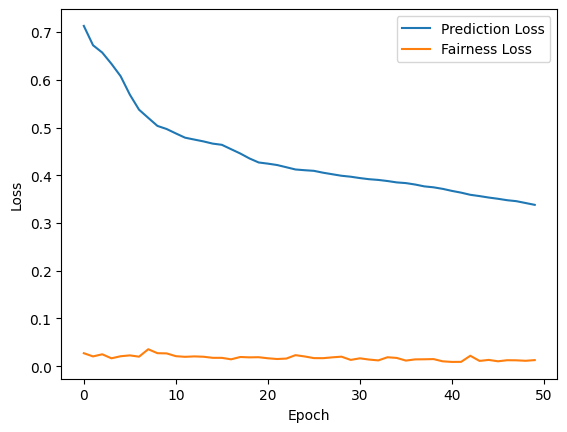

In [52]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
eo_model = trainer_eo_fair(model, train_loader, optim, device, 50, 0.95)

Epoch 0 p_loss: 0.3668713718652725, f_loss: -0.0021720435470342636
Epoch 10 p_loss: 0.2730211205780506, f_loss: -0.048016381449997425
Epoch 20 p_loss: 0.3067722376435995, f_loss: -0.09622176364064217
Epoch 30 p_loss: 0.33272741734981537, f_loss: -0.15190428402274847
Epoch 40 p_loss: 0.37087566778063774, f_loss: -0.1897438745945692


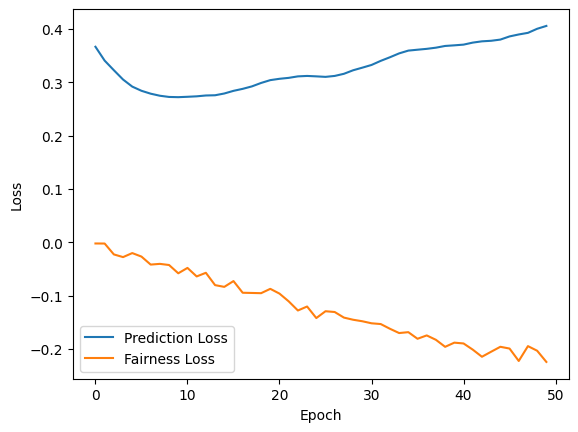

In [53]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
eodd_model = trainer_eodd_fair(model, train_loader, optim, device, 50, 0.95)

In [74]:
seeds = list(range(2021, 2051))
n = 200
EI_fairness = np.empty((len(seeds), seq_len))
efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))

for seed in seeds:
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([2])
    for i in range(seq_len):
        _, e, _data = test_fb_fair(ei_model, test_loader, [1,2], device, delta_effort=new_budget.item())
        new_budget = 2+(2-torch.mean(torch.sum(torch.abs(e), dim=1)))
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, ei_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        efforts_baseline.append(e)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        EI_fairness[seed-2021, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

In [64]:
seeds = list(range(2021, 2051))
n = 200
DP_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))

for seed in seeds:
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([2])
    for i in range(seq_len):
        _, _data = test_dp_fair(dp_model, test_loader, device)
        new_budget = 2+(2-torch.mean(torch.sum(torch.abs(e), dim=1)))
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, dp_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        DP_fairness[seed-2021, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

In [66]:
seeds = list(range(2021, 2051))
n = 200
EO_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))

for seed in seeds:
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([2])
    for i in range(seq_len):
        _, _data = test_eo_fair(eo_model, test_loader, device)
        new_budget = 2+(2-torch.mean(torch.sum(torch.abs(e), dim=1)))
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, eo_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        EO_fairness[seed-2021, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

In [67]:
seeds = list(range(2021, 2051))
n = 200
EODD_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))

for seed in seeds:
    s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([2])
    for i in range(seq_len):
        _, _data = test_eodd_fair(eo_model, test_loader, device)
        new_budget = 2+(2-torch.mean(torch.sum(torch.abs(e), dim=1)))
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, eodd_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        EODD_fairness[seed-2021, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

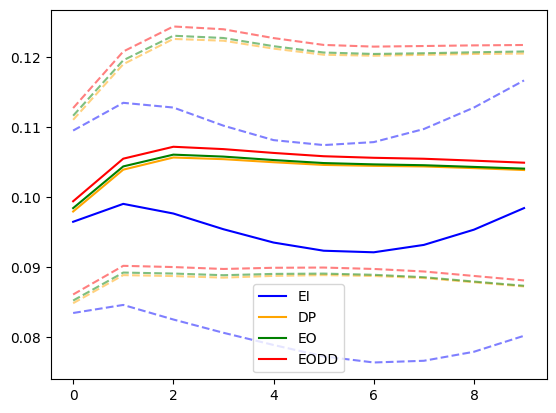

In [75]:
EI_fairness_tl = np.mean(EI_fairness, axis=0)
timeline = range(seq_len)   
EI_top = EI_fairness_tl + np.std(EI_fairness, axis=0)
EI_bottom = EI_fairness_tl - np.std(EI_fairness, axis=0)
DP_fairness_tl = np.mean(DP_fairness, axis=0)
DP_top = DP_fairness_tl + np.std(DP_fairness, axis=0)
DP_bottom = DP_fairness_tl - np.std(DP_fairness, axis=0)
EO_fairness_tl = np.mean(EO_fairness, axis=0)
EO_top = EO_fairness_tl + np.std(EO_fairness, axis=0)
EO_bottom = EO_fairness_tl - np.std(EO_fairness, axis=0)
EODD_fairness_tl = np.mean(EODD_fairness, axis=0)
EODD_top = EODD_fairness_tl + np.std(EODD_fairness, axis=0)
EODD_bottom = EODD_fairness_tl - np.std(EODD_fairness, axis=0)

plt.plot(timeline, EI_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EI_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EI_fairness_tl, color='blue', label='EI')
plt.plot(timeline, DP_top, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, DP_bottom, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, DP_fairness_tl, color='orange', label='DP')
plt.plot(timeline, EO_top, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EO_bottom, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EO_fairness_tl, color='green', label='EO')
plt.plot(timeline, EODD_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EODD_bottom, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EODD_fairness_tl, color='red', label='EODD')
plt.legend()
plt.savefig('baseline_fairness_plot toy dataset budget = 20.png')
plt.show()

In [59]:
"""""
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)

plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)

plt.plot(timeline, model_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom, color='red', linestyle='dashed', alpha=0.5)

plt.plot(timeline, baseline_top, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, baseline_bottom, color='green', linestyle='dashed', alpha=0.5)
"""""
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')

plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness')

plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')

plt.plot(timeline, EI_fairness_tl, color='green', label='EI Fairness')
plt.plot(timeline, DP_fairness_tl, color='purple', label='DP Fairness')
plt.plot(timeline, EO_fairness_tl, color='black', label='EO Fairness')
plt.plot(timeline, EODD_fairness_tl, color='yellow', label='EODD Fairness')
plt.title(f'Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.savefig("Toy Example Results - 30 seeds averaged budget = " + str(budget) + ".png")
plt.show()

NameError: name 'og_fairness_tl' is not defined

(array([ 0.,  0.,  0.,  0.,  3.,  8.,  8., 10., 11.,  7., 12.,  6., 12.,
         4.,  5.,  4.,  4.,  1.,  1.,  0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

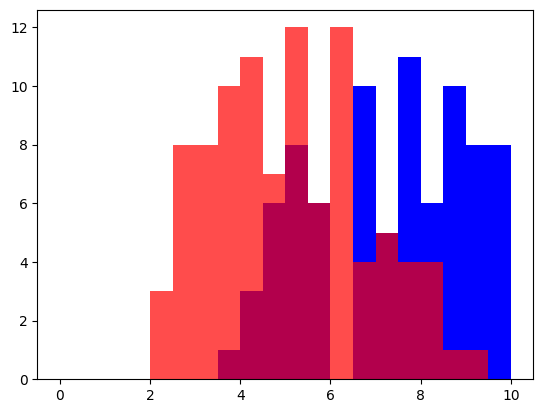

In [63]:
pos_efforts = efforts.view(n, seq_len, 2)[s0.squeeze() == 1, :]
ps = []
for i in range(len(pos_efforts)):
    ps.append(torch.sum(torch.abs(pos_efforts[i])).item())

plt.hist(ps, color='blue', range=(0, 10), bins=20)

neg_efforts = efforts.view(n, seq_len, 2)[s0.squeeze() == 0, :]
ns = []
for i in range(len(neg_efforts)):
    ns.append(torch.sum(torch.abs(neg_efforts[i])).item())

plt.hist(ns, color='red', alpha=0.7, range=(0, 10), bins=20)

In [64]:
pos_efforts = efforts_baseline[0].view(n, seq_len, 2)[s0.squeeze() == 1, :]
ps = []
for i in range(len(pos_efforts)):
    ps.append(torch.sum(torch.abs(pos_efforts[i])).item())

plt.hist(ps, color='blue', range=(0, 10), bins=20)

neg_efforts = efforts_baseline[0].view(n, seq_len, 2)[s0.squeeze() == 0, :]
ns = []
for i in range(len(neg_efforts)):
    ns.append(torch.sum(torch.abs(neg_efforts[i])).item())

plt.hist(ns, color='red', alpha=0.7, range=(0, 10), bins=20)

RuntimeError: shape '[200, 10, 2]' is invalid for input of size 333

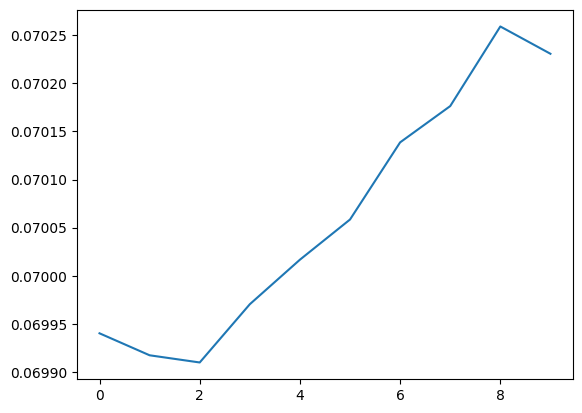

In [ ]:
distance_ei = []
efforts = []
data = []

for i in range(seq_len):
    _, e, _data = test_fb_fair(new_model, test_loader, [1,2], device)
    test_dataset = SimpleDataset(_data[:, :-1], _data[:, -1])
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
    efforts.append(e)
    distance = compute_distance_loss(_data)
    distance_ei.append(distance.item())
    data.append(_data)

plt.plot(np.arange(0, len(distance_ei), 1), distance_ei)



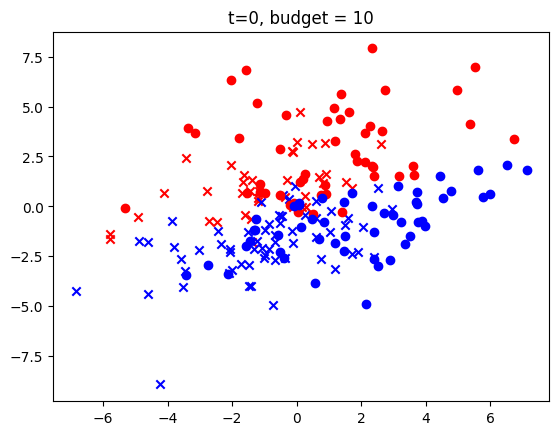

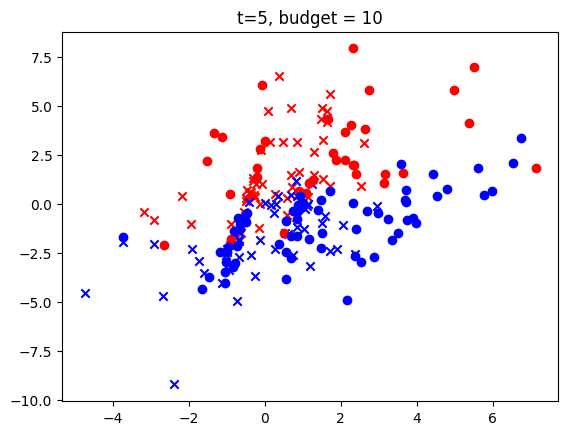

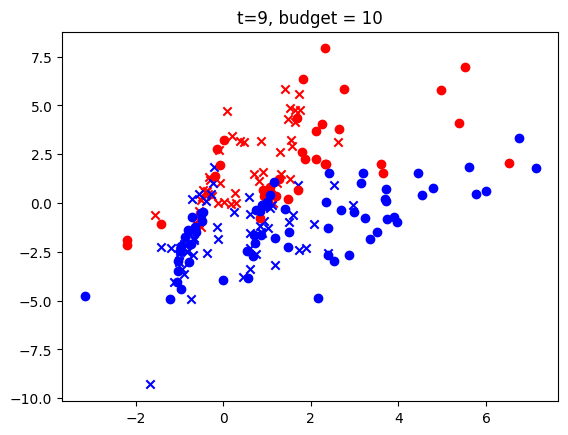

In [ ]:
steps = [0, 5, 9]

s_test = data[:, 0, 0]

for i in steps:
    x_hat_test = data[:, i, 1:3]
    y_hat_test = data[:, i, -1]
    x_neg = x_hat_test[s_test == 0, :]
    y_neg = y_hat_test[s_test == 0]
    y_neg = y_neg.squeeze().round()
    x_pos = x_hat_test[s_test == 1, :]
    y_pos = y_hat_test[s_test == 1]
    y_pos = y_pos.squeeze().round()

    plt.scatter(x_neg[y_neg==0, 0], x_neg[y_neg==0, 1], marker='x', color='red')
    plt.scatter(x_neg[y_neg==1, 0], x_neg[y_neg==1, 1], marker='x', color='blue')
    plt.scatter(x_pos[y_pos==0, 0], x_pos[y_pos==0, 1], marker='o', color='red')
    plt.scatter(x_pos[y_pos==1, 0], x_pos[y_pos==1, 1], marker='o', color='blue')
    plt.title(f't={i}, budget = {10}')

    plt.show()